In [1]:
wt_url = 'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5692nnn/GSM5692829/suppl/GSM5692829_mes_wt.hic'
mcph1_url = 'https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5692nnn/GSM5692830/suppl/GSM5692830_mes_mcph1.hic'

In [2]:
!pip install hic-straw
import straw as straw

  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for hic-straw: filename=hic_straw-1.0.0.1-cp37-cp37m-linux_x86_64.whl size=1092595 sha256=afcb0da121eba8dcf293c20bd5081daa228663375795f46cf1c8fb71671c646f
  Stored in directory: /root/.cache/pip/wheels/2c/b3/75/235c8435353edf87ad96dff8cc468ddd242aa0f0e25022ebf2
Successfully built hic-straw


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from numpy import linalg as lin_alg
from scipy.sparse import coo_matrix
from scipy import stats

In [4]:
def grab_expected_vector(filepath: str, chrom1: str, resolution: int, norm: str):
    footer = straw.getNormExpVectors(filepath, chrom1, chrom1, "oe", norm, "BP", resolution)
    return footer.expectedValues

In [5]:
wt_expected = grab_expected_vector(wt_url, '1', 100000, 'KR')
mcph1_expected = grab_expected_vector(mcph1_url, '1', 100000, 'KR')

In [6]:
def normalize(y):
  y = np.asarray(y)
  y = y/y[0]
  return y

In [7]:
wt_expected = normalize(wt_expected)
mcph1_expected = normalize(mcph1_expected)

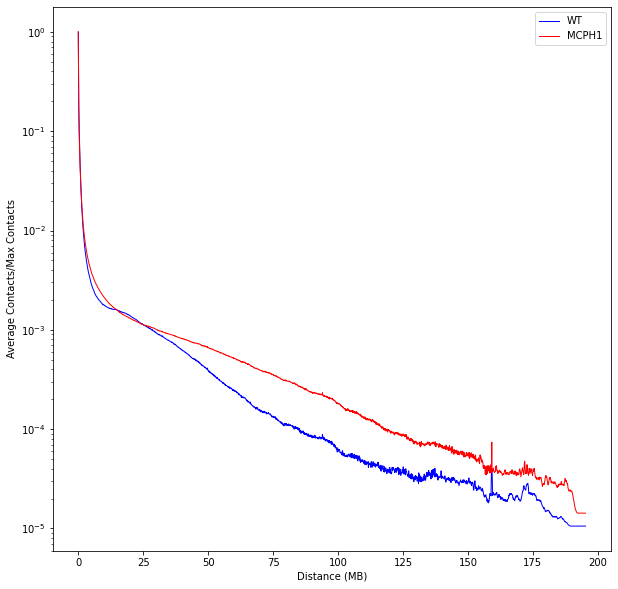

In [15]:
# 1 = 1MB, 0.1 = 100KB for x axis scaling
def plot_expected_contact_vs_dist(wt_expected, mcph1_expected):
  xd = np.asarray(np.linspace(0, len(wt_expected)-1, len(wt_expected)))*.1
  #plt.rc('font', size=40)
  #plt.rc('axes', titlesize=100)
  #plt.rc('axes', labelsize=60)
  #plt.rc('xtick', labelsize=60)
  #plt.rc('ytick', labelsize=60)
  #plt.rc('legend', fontsize=80)
  #plt.rc('figure', titlesize=100)

  fig, ax = plt.subplots(figsize=(10,10))
  plt.semilogy(xd, wt_expected, 'b-', label='WT', linewidth=1)
  plt.semilogy(xd, mcph1_expected, 'r-', label='MCPH1', linewidth=1)

  plt.ylabel('Average Contacts/Max Contacts')
  plt.xlabel('Distance (MB)')
  ax.legend()
  #ax.legend(prop={'size': 100})

  plt.show()
  plt.savefig('log_contact_vs_dist.png', dpi=300, bbox_inches='tight')
  plt.close()
plot_expected_contact_vs_dist(wt_expected, mcph1_expected)

In [16]:
REDMAP = LinearSegmentedColormap.from_list("bright_red", [(1, 1, 1), (1, 0, 0)])

BLUEREDMAP = LinearSegmentedColormap.from_list("bright_red", [(0, 0, 1), (0, 0, 0), (1, 0, 0)])


def plot_map_neg_pos(dense_matrix, size, outfile):
    fig, ax = plt.subplots(figsize=size)
    maxval = np.mean(np.abs(dense_matrix))
    im = ax.matshow(dense_matrix, cmap=BLUEREDMAP, vmin=-maxval, vmax=maxval)
    fig.colorbar(im)
    plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [17]:
def grab_hic_region(hic_file, chrom1, resolution, norm, mtype="observed"):
    result = straw.straw(mtype, norm, hic_file, str(chrom1), str(chrom1), 'BP', resolution)
    row_indices, col_indices, data = list(), list(), list()
    for record in result:
        row_indices.append(record.binX)
        col_indices.append(record.binY)
        data.append(record.counts)
        if record.binX != record.binY:
            row_indices.append(record.binY)
            col_indices.append(record.binX)
            data.append(record.counts)
    row_indices = (np.asarray(row_indices)) / resolution
    col_indices = (np.asarray(col_indices)) / resolution
    width = int(np.max(row_indices) + 1)
    matrix = coo_matrix((data, (row_indices.astype(int), col_indices.astype(int))),
                        shape=(width, width)).toarray()
    matrix[np.isnan(matrix)] = 0
    matrix[np.isinf(matrix)] = 0
    return matrix

In [18]:

def slice_matrix(matrix, indices):
    matrix = matrix[indices, :]
    return matrix[:, indices]


def slice_all(z1, z2, r1, r2, indices):
    z1 = slice_matrix(z1, indices)
    z2 = slice_matrix(z2, indices)
    r1 = slice_matrix(r1, indices)
    r2 = slice_matrix(r2, indices)
    return z1, z2, r1, r2


def paired_remove_sparse_rows(z1, z2, r1, r2):
    indices = np.array(np.where(np.sum(z1 > 0, axis=1) > .5 * np.shape(z1)[1])[0])
    z1, z2, r1, r2 = slice_all(z1, z2, r1, r2, indices)
    indices = np.array(np.where(np.sum(z2 > 0, axis=1) > .5 * np.shape(z2)[1])[0])
    return slice_all(z1, z2, r1, r2, indices)


def get_corr_matrix(z):
    d_z = pd.DataFrame(z)
    d_z = d_z.corr()
    np.fill_diagonal(d_z.values, 0.0)
    d_z[np.isinf(d_z)] = 0
    d_z[np.isnan(d_z)] = 0
    return d_z


def get_sorted_vector(vector):
    sorted_vector = list(vector)
    sorted_vector.sort(key=lambda s: float(s))  # reverse=True
    return sorted_vector


def non_zero_median(matrix, indx1, indx2):
    temp = matrix[indx1, :][:, indx2].copy()
    # return np.mean(temp[temp>0])
    return stats.gmean(temp[temp > 0])


def non_zero_median2(temp):
    return stats.gmean(temp[temp > 0])


def get_all_nonzero_medians(oe_c1, pos_indices, neg_indices):
    aa = non_zero_median(oe_c1, pos_indices, pos_indices)
    ab = non_zero_median(oe_c1, pos_indices, neg_indices)
    bb = non_zero_median(oe_c1, neg_indices, neg_indices)
    return aa, ab, bb, np.sqrt(aa * bb) / ab


def get_eig_and_saddle(oe_c):
    corr_matrix = get_corr_matrix(oe_c)
    eig_vals, eig_vecs = lin_alg.eig(corr_matrix)
    primary_eig = np.squeeze(eig_vecs[:, 0])
    primary_eig = primary_eig / np.max(np.abs(primary_eig))
    sort_eig_vecs = get_sorted_vector(primary_eig)
    saddle = np.outer(sort_eig_vecs, sort_eig_vecs)
    return primary_eig, saddle, corr_matrix

In [19]:
def run_ab_enrichment_analysis(hic_file1, hic_file2, chrom1, resolution, norm, mtype):
    raw_c1 = grab_hic_region(hic_file1, chrom1, resolution, norm)
    raw_c2 = grab_hic_region(hic_file2, chrom1, resolution, norm)
    oe_c1 = grab_hic_region(hic_file1, chrom1, resolution, norm, mtype)
    oe_c2 = grab_hic_region(hic_file2, chrom1, resolution, norm, mtype)
    oe_c1, oe_c2, raw_c1, raw_c2 = paired_remove_sparse_rows(oe_c1, oe_c2, raw_c1, raw_c2)
    primary_eig1, saddle1, corr1 = get_eig_and_saddle(oe_c1)
    primary_eig2, saddle2, corr2 = get_eig_and_saddle(oe_c2)
    pos_cutoff1 = np.median(primary_eig1[primary_eig1 > 0])
    neg_cutoff1 = np.median(primary_eig1[primary_eig1 < 0])
    max_pos_indices = np.array(np.where((primary_eig1 > pos_cutoff1))[0])
    max_neg_indices = np.array(np.where((primary_eig1 < neg_cutoff1))[0])
    oe_indices1 = np.argsort(primary_eig1)
    oe_indices2 = np.argsort(primary_eig1)

    corr_ordered_c1 = np.asarray(corr1)[oe_indices1, :][:, oe_indices1]
    corr_ordered_c2 = np.asarray(corr2)[oe_indices2, :][:, oe_indices2]
    saddle3 = np.triu(corr_ordered_c2, k=1) + np.tril(corr_ordered_c1, k=-1)
    plot_map_neg_pos(saddle3, (10, 10), 'corr_vs_oe_' + str(chrom1) + "_" +
                     str(resolution) + ".png")

    aa, ab, bb, zm1 = get_all_nonzero_medians(oe_c1, max_pos_indices, max_neg_indices)
    print("max_aa_C1", aa, "max_ab_C1", ab, "max_bb_C1", bb, "max_enrichment_C1", np.sqrt(aa * bb) / ab)
    aa, ab, bb, zm2 = get_all_nonzero_medians(oe_c2, max_pos_indices, max_neg_indices)
    print("max_aa_C2", aa, "max_ab_C2", ab, "max_bb_C2", bb, "max_enrichment_C2", np.sqrt(aa * bb) / ab)


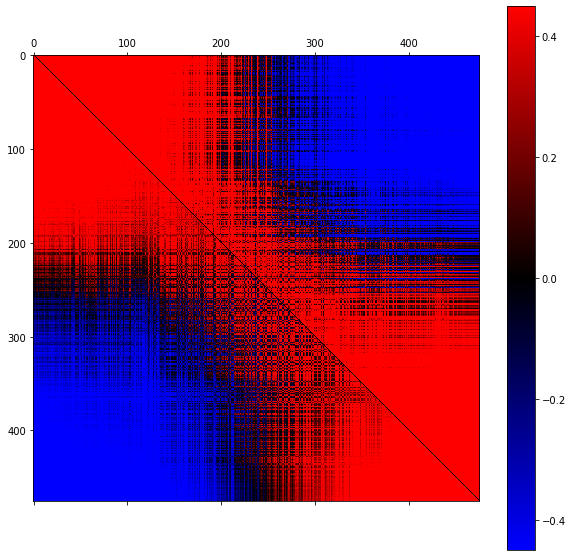

max_aa_C1 1.2474928751704484 max_ab_C1 0.2720016102677279 max_bb_C1 1.4445862239821416 max_enrichment_C1 4.935365221147788
max_aa_C2 1.3139368907821178 max_ab_C2 0.42215790572069545 max_bb_C2 1.2841807390268027 max_enrichment_C2 3.076985164703805


In [20]:
run_ab_enrichment_analysis(wt_url, mcph1_url, '11', 250000, 'KR', 'oe')
# for the paper, we used 250kb eigenvectors and used chr11
# but you can also run this at higher resolutions (e.g. 100kb)
# or for different chromosomes
# sometimes, the eigenvector on larger chromosomes (e.g. chr1) can correlate to 
# the long vs short arms instead of the AB-compartmentalization signal
# this is something that should be checked in Juicebox before running
# run_ab_enrichment_analysis(wt_url, mcph1_url, '11', 100000, 'KR', 'oe')